In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from torch.utils.data import TensorDataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cpu is available.


In [3]:
## Sklearn Stuff
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## Dataset preparation

In [25]:
train_instances = pd.read_csv("../data_forecasting/Train.csv")
train_instances['timestamp'] = train_instances['year'].astype('str') + "-" + train_instances['month'].astype('str')
train_instances.drop(columns={'region', 
                      'district', 
                      'stock_initial', 
                      'stock_received', 
                      'stock_adjustment',
                      'stock_end',
                      'average_monthly_consumption',
                      'stock_stockout_days',
                      'stock_ordered'},
                      inplace=True)
train_instances['timestamp']=pd.to_datetime(train_instances['timestamp'])
train_instances.index= train_instances.timestamp
train_instances.drop(columns={'timestamp'},inplace=True)

In [26]:
## Sort Dataframe by Date - Causality in Preds
train_instances.sort_values(by='timestamp', inplace=True)
train_instances.tail(20)

,year,month,site_code,product_code,stock_distributed
timestamp,,,,,
2019-06-01,2019,6,C2066,AS27137,20
2019-06-01,2019,6,C2066,AS27139,0
2019-06-01,2019,6,C2066,AS27000,0
2019-06-01,2019,6,C2066,AS27134,0
2019-06-01,2019,6,C2066,AS46000,0
2019-06-01,2019,6,C2066,AS21126,0
2019-06-01,2019,6,C5001,AS27134,25
2019-06-01,2019,6,C5001,AS27000,1
2019-06-01,2019,6,C1007,AS27132,54


## Ideia 1
    - completar a tabela com zeros em locais em que não é reportado (padding)
    - treinar batches de LSTM com mesmo tamanho da input sequence

In [27]:
len(train_instances[train_instances.site_code=='C1007'])

308

In [28]:
len(train_instances[train_instances.site_code=='C5001'])

135

In [29]:
len(train_instances[train_instances.site_code=='C2052'])

154

<AxesSubplot:xlabel='timestamp'>

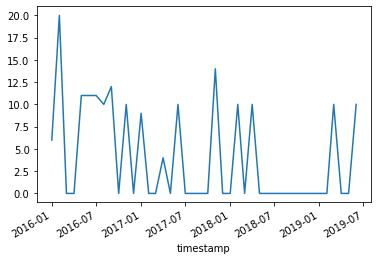

In [31]:
train_instances['stock_distributed'][(train_instances.site_code=='C2052') 
                                     & (train_instances.product_code=='AS27000')].plot()

In [7]:
dummies_product = pd.get_dummies(train_instances.product_code, prefix='product')
dummies_site = pd.get_dummies(train_instances.site_code, prefix='site')
train_df = pd.concat([train_instances,dummies_product, dummies_site], axis=1).drop(columns={'product_code', 'site_code'})
train_df

,year,month,stock_distributed,product_AS17005,product_AS21126,product_AS27000,product_AS27132,product_AS27133,product_AS27134,product_AS27137,...,site_C5015,site_C5016,site_C5017,site_C5018,site_C5019,site_C5020,site_C5021,site_C5060,site_C5063,site_C5066
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01,2016,1,2,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2016-01-01,2016,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-01,2016,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-01,2016,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2016-01-01,2016,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-01,2019,6,23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-06-01,2019,6,11,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2019-06-01,2019,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
## feature definition
features = ['year','month','site_code_encoded','product_code_encoded']
label = ['stock_distributed']

In [9]:
features = train_df.loc[:, train_df.columns != 'stock_distributed']
labels = train_df.loc[:, train_df.columns == 'stock_distributed']

In [1]:
features.tail()

NameError: name 'features' is not defined

In [ ]:
## Min/Max Scaler
feature_scaler = MinMaxScaler()
label_scaler = MinMaxScaler()

features_scaled = feature_scaler.fit_transform(features)
label_scaled = label_scaler.fit_transform(labels)

In [ ]:
ix = -2

In [ ]:
train_scaled[ix]

In [ ]:
label_scaled[ix]

In [ ]:
print(len(features_scaled))

In [ ]:
train_size = 0.8

train_features = features_scaled[:int(train_size*(len(features_scaled)))]
train_labels = label_scaled[:int(train_size*(len(features_scaled)))]

valid_features = features_scaled[int(train_size*(len(features_scaled))):]
valid_labels = label_scaled[int(train_size*(len(features_scaled))):]

In [ ]:
## Pytorch Data loaders
batch_size = 16

t_features = torch.Tensor(train_features)
t_targets = torch.Tensor(train_labels)

v_features = torch.Tensor(valid_features)
v_targets = torch.Tensor(valid_labels)

train_dataset = TensorDataset(t_features, t_targets)
val_dataset = TensorDataset(v_features, v_targets)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [ ]:
x,y = next(iter(train_loader))

In [ ]:
dir(train_dataset)

## PyTorch Modeling

In [ ]:
class LSTMPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers, dropout):
        super(LSTMPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout=dropout
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        self.reset_hidden_state()
        
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )
        last_time_step = \
          lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [ ]:
model_params = {
    'n_features': t_features.shape[1],
    'n_hidden': 256,
    'seq_len': 1,
    'n_layers': 2,
    'dropout': 0.2
}

train_params = {
    'learning_rate': 1e-3,
    'weight_decay': 1e-6,
    'n_epochs': 5
    
}

In [ ]:
def train(train_data, valid_data, model_params, train_params):
    ## Train Definitions
    N_EPOCHS = train_params['n_epochs']
    model = LSTMPredictor(**model_params)
    loss_fn = nn.MSELoss(reduction="mean")
    optimizer = optim.Adam(model.parameters(), 
                           lr=train_params['learning_rate'], 
                           weight_decay=train_params['weight_decay'])
    ## Start training
    for epoch in range(N_EPOCHS):
        print(f'Epoch {epoch}')
        for step, (x,y) in enumerate(train_data):
            model.train()
            optimizer.zero_grad()
            model.reset_hidden_state()
            output = model(x)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
            if step%500 == 0:
                for step_valid, (x_valid,y_valid) in enumerate(valid_data):
                    model.eval()
                    #with torch.no_grad():
                    output_valid = model.forward(x_valid)
                    mse = mean_squared_error(y_valid.detach().numpy(), output_valid.detach().numpy())
                print(f"Iteration: {step}; Loss: {loss.item()}; MSE: {mse}")
    return model.eval()

In [ ]:
model_lstm = train(train_loader, val_loader, model_params, train_params)

## Check Batches
- https://github.com/wcneill/jn-ml-textbook/blob/master/Deep%20Learning/04%20Recurrent%20Networks/pytorch13b_LSTM.ipynb
- https://medium.com/analytics-vidhya/pytorch-lstms-for-time-series-forecasting-of-indian-stocks-8a49157da8b9